In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

filename = 'data.csv'
raw = pd.read_csv(filename)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
raw['shot_made_flag'] = raw['shot_made_flag'].fillna('0')
print(raw.shape)
print(raw.describe())
print(raw.isnull().any())
print(raw.dtypes)
raw.head()

(30697, 25)
       game_event_id       game_id           lat         loc_x         loc_y  \
count   30697.000000  3.069700e+04  30697.000000  30697.000000  30697.000000   
mean      249.190800  2.476407e+07     33.953192      7.110499     91.107535   
std       150.003712  7.755175e+06      0.087791    110.124578     87.791361   
min         2.000000  2.000001e+07     33.253300   -250.000000    -44.000000   
25%       110.000000  2.050008e+07     33.884300    -68.000000      4.000000   
50%       253.000000  2.090035e+07     33.970300      0.000000     74.000000   
75%       368.000000  2.960047e+07     34.040300     95.000000    160.000000   
max       659.000000  4.990009e+07     34.088300    248.000000    791.000000   

                lon  minutes_remaining        period      playoffs  \
count  30697.000000       30697.000000  30697.000000  30697.000000   
mean    -118.262690           4.885624      2.519432      0.146562   
std        0.110125           3.449897      1.153665     

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  playoffs   season  \
0    167     72 -118.1028                 10       1         0  2000-01   
1   -157      0 -118.4268                 10       1         0  2000-01   
2   -101    135 -118.3708                  7       1         0  2000-01   
3    138    175 -118.1318                  6       1         0  2000-01   
4      0      0 -118.2698                  6       2         0  2000-01   

   seconds_remaining  shot_distance shot_made_flag       shot_type  \
0                 27             18              0  2PT Field Goal   
1                 22             15            0.0  2PT Field Goal   
2                 45             16            1.0  2PT Field Goal   
3                 52             22            0.0  2PT Field Goal   
4                 19              0            1.0  2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \
0          Right Side(R)        Mid-Range        16-24 ft.  1610612747   
1           Left Side(L)        Mid-Range         8-16 ft.  1610612747   
2   Left Side Center(LC)        Mid-Range        16-24 ft.  1610612747   
3  Right Side Center(RC)        Mid-Range        16-24 ft.  1610612747   
4              Center(C)  Restricted Area  Less Than 8 ft.  1610612747   

            team_name   game_date    matchup opponent  shot_id  
0  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        1  
1  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        2  
2  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        3  
3  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        4  
4  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        5

In [2]:
kobe = raw[pd.notnull(raw['shot_made_flag'])]
print(kobe.shape)

(30697, 25)


Text(0.5, 1.0, 'lat and lon')

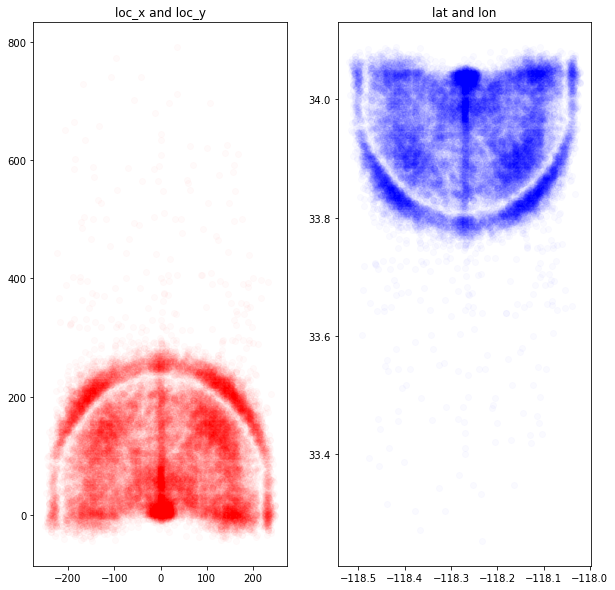

In [3]:
alpha = 0.02
plt.figure(figsize=(10,10))

#loc_x and loc_y
plt.subplot(121)
plt.scatter(kobe.loc_x, kobe.loc_y, color = 'red', alpha = alpha)
plt.title('loc_x and loc_y')

#lat and lon
plt.subplot(122)
plt.scatter(kobe.lon, kobe.lat, color = 'blue', alpha = alpha)
plt.title('lat and lon')

In [4]:
raw['dist'] = np.sqrt(raw['loc_x'] ** 2 + raw['loc_y'] ** 2)#欧氏距离

loc_x_zero = raw['loc_x'] == 0

raw['angle'] = np.array([0] * len(raw))
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])
raw['angle'][loc_x_zero] = np.pi / 2

<ipython-input-4-5b5a444b45cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])


In [5]:
print(kobe.action_type.unique())
print(kobe.combined_shot_type.unique())
print(kobe.shot_type.unique())
print(kobe.shot_type.value_counts())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Driving Layup Shot' 'Reverse Layup Shot' 'Reverse Dunk Shot'
 'Slam Dunk Shot' 'Turnaround Jump Shot' 'Tip Shot' 'Running Hook Shot'
 'Alley Oop Dunk Shot' 'Dunk Shot' 'Alley Oop Layup shot'
 'Running Dunk Shot' 'Driving Finger Roll Shot' 'Running Layup Shot'
 'Finger Roll Shot' 'Fadeaway Jump Shot' 'Follow Up Dunk Shot' 'Hook Shot'
 'Turnaround Hook Shot' 'Running Tip Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Reverse Layup Shot'
 'Driving Finger Roll Layup Shot' 'Fadeaway Bank shot' 'Pullup Jump shot'
 'Finger Roll Layup Shot' 'Turnaround Fadeaway shot'
 'Driving Reverse Layup Shot' 'Driving Slam Dunk Shot'
 'Step Back Jump shot' 'Reverse Slam Dunk Shot' 'Turnaround Bank shot'
 'Running Finger Roll Layup Shot' 'Floating Jump shot'
 'Putback Slam Dunk Shot' 'Running Bank shot' 'Driving Bank shot'
 'Putback Layup Shot'

In [6]:
kobe['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [7]:
raw['season'] = raw['season'].apply(lambda x: int(x.split('-')[1]))
raw['season'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0], dtype=int64)

In [8]:
print(kobe['team_id'].unique())
print(kobe['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


In [9]:
pd.DataFrame({'matchup':kobe.matchup, 'opponent':kobe.opponent})

matchup opponent
0        LAL @ POR      POR
1        LAL @ POR      POR
2        LAL @ POR      POR
3        LAL @ POR      POR
4        LAL @ POR      POR
5        LAL @ POR      POR
6        LAL @ POR      POR
7        LAL @ POR      POR
8        LAL @ POR      POR
9        LAL @ POR      POR
10       LAL @ POR      POR
11     LAL vs. UTA      UTA
12     LAL vs. UTA      UTA
13     LAL vs. UTA      UTA
14     LAL vs. UTA      UTA
15     LAL vs. UTA      UTA
16     LAL vs. UTA      UTA
17     LAL vs. UTA      UTA
18     LAL vs. UTA      UTA
19     LAL vs. UTA      UTA
20     LAL vs. UTA      UTA
21     LAL vs. UTA      UTA
22     LAL vs. UTA      UTA
23     LAL vs. UTA      UTA
24     LAL vs. UTA      UTA
25     LAL vs. UTA      UTA
26     LAL vs. UTA      UTA
27     LAL vs. UTA      UTA
28     LAL vs. UTA      UTA
29     LAL vs. UTA      UTA
30     LAL vs. UTA      UTA
31     LAL vs. UTA      UTA
32       LAL @ VAN      VAN
33       LAL @ VAN      VAN
34       LAL @ VAN      VAN
35       LAL @ VAN      VAN
36       LAL @ VAN      VAN
37       LAL @ VAN      VAN
38       LAL @ VAN      VAN
39       LAL @ VAN      VAN
40       LAL @ VAN      VAN
41       LAL @ VAN      VAN
42       LAL @ VAN      VAN
43       LAL @ VAN      VAN
44       LAL @ VAN      VAN
45       LAL @ VAN      VAN
46       LAL @ VAN      VAN
47       LAL @ VAN      VAN
48       LAL @ VAN      VAN
49       LAL @ VAN      VAN
50       LAL @ VAN      VAN
51       LAL @ VAN      VAN
52     LAL vs. LAC      LAC
53     LAL vs. LAC      LAC
54     LAL vs. LAC      LAC
55     LAL vs. LAC      LAC
56     LAL vs. LAC      LAC
57     LAL vs. LAC      LAC
58     LAL vs. LAC      LAC
59     LAL vs. LAC      LAC
60     LAL vs. LAC      LAC
61     LAL vs. LAC      LAC
62     LAL vs. LAC      LAC
63     LAL vs. LAC      LAC
64     LAL vs. LAC      LAC
65     LAL vs. LAC      LAC
66       LAL @ HOU      HOU
67       LAL @ HOU      HOU
68       LAL @ HOU      HOU
69       LAL @ HOU      HOU
70       LAL @ HOU      HOU
71       LAL @ HOU      HOU
72       LAL @ HOU      HOU
73       LAL @ HOU      HOU
74       LAL @ HOU      HOU
75       LAL @ HOU      HOU
76       LAL @ HOU      HOU
77       LAL @ HOU      HOU
78       LAL @ HOU      HOU
79       LAL @ HOU      HOU
80       LAL @ HOU      HOU
81       LAL @ HOU      HOU
82       LAL @ SAS      SAS
83       LAL @ SAS      SAS
84       LAL @ SAS      SAS
85       LAL @ SAS      SAS
86       LAL @ SAS      SAS
87       LAL @ SAS      SAS
88       LAL @ SAS      SAS
89       LAL @ SAS      SAS
90       LAL @ SAS      SAS
91       LAL @ SAS      SAS
92       LAL @ SAS      SAS
93       LAL @ SAS      SAS
94       LAL @ SAS      SAS
95       LAL @ SAS      SAS
96       LAL @ SAS      SAS
97       LAL @ SAS      SAS
98       LAL @ SAS      SAS
99       LAL @ SAS      SAS
100      LAL @ SAS      SAS
101      LAL @ SAS      SAS
102      LAL @ SAS      SAS
103      LAL @ SAS      SAS
104      LAL @ SAS      SAS
105      LAL @ SAS      SAS
106      LAL @ SAS      SAS
107      LAL @ SAS      SAS
108      LAL @ SAS      SAS
109      LAL @ SAS      SAS
110      LAL @ SAS      SAS
111      LAL @ SAS      SAS
112      LAL @ SAS      SAS
113    LAL vs. HOU      HOU
114    LAL vs. HOU      HOU
115    LAL vs. HOU      HOU
116    LAL vs. HOU      HOU
117    LAL vs. HOU      HOU
118    LAL vs. HOU      HOU
119    LAL vs. HOU      HOU
120    LAL vs. HOU      HOU
121    LAL vs. HOU      HOU
122    LAL vs. HOU      HOU
123    LAL vs. HOU      HOU
124    LAL vs. HOU      HOU
125    LAL vs. HOU      HOU
126    LAL vs. HOU      HOU
127    LAL vs. HOU      HOU
128    LAL vs. HOU      HOU
129    LAL vs. HOU      HOU
130    LAL vs. HOU      HOU
131    LAL vs. HOU      HOU
132    LAL vs. HOU      HOU
133    LAL vs. HOU      HOU
134    LAL vs. HOU      HOU
135    LAL vs. HOU      HOU
136    LAL vs. HOU      HOU
137    LAL vs. HOU      HOU
138    LAL vs. HOU      HOU
139    LAL vs. HOU      HOU
140    LAL vs. HOU      HOU
141    LAL vs. HOU      HOU
142    

Text(0.5, 1.0, 'dist an shot_distance')

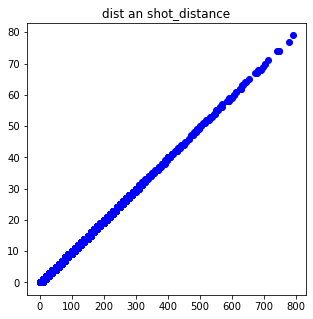

In [10]:
plt.figure(figsize = (5, 5))
plt.scatter(raw.dist, raw.shot_distance, color = 'blue')
plt.title('dist an shot_distance')

In [11]:
gs = kobe.groupby('shot_zone_area')
print(kobe['shot_zone_area'].value_counts())
print(len(gs))

Center(C)                13455
Right Side Center(RC)     4776
Right Side(R)             4588
Left Side Center(LC)      4044
Left Side(L)              3751
Back Court(BC)              83
Name: shot_zone_area, dtype: int64
6


Text(0.5, 1.0, 'shot_zone_range')

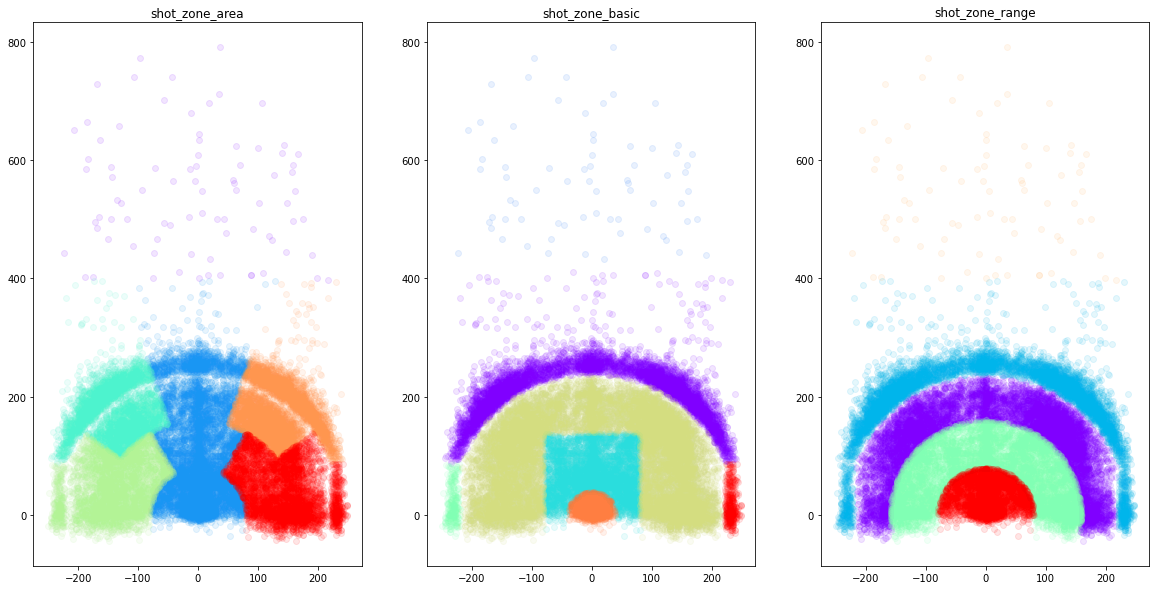

In [12]:
import matplotlib.cm as cm
plt.figure(figsize = (20, 10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color = c, alpha = alpha)
        
#shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

#shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

#shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [13]:
drops = ['shot_id','team_id','team_name','shot_zone_area','shot_zone_range','shot_zone_basic',\
        'matchup','lon','lat','seconds_remaining','minutes_remaining',\
         'shot_distance','loc_x','loc_y','game_event_id','game_id','game_date']
for drop in drops:
    raw =  raw.drop(drop, 1)

In [14]:
print(raw['combined_shot_type'].value_counts())
pd.get_dummies(raw['combined_shot_type'], prefix = 'combined_shot_type')[0:2]

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64


combined_shot_type_Bank Shot  combined_shot_type_Dunk  \
0                             0                        0   
1                             0                        0   

   combined_shot_type_Hook Shot  combined_shot_type_Jump Shot  \
0                             0                             1   
1                             0                             1   

   combined_shot_type_Layup  combined_shot_type_Tip Shot  
0                         0                            0  
1                         0                            0

In [15]:
categorical_vals = ['action_type','combined_shot_type','shot_type','opponent', 'period', 'season']
for var in categorical_vals:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix = var)], 1)
    raw = raw.drop(var, 1)

In [16]:
train_kobe = raw[pd.notnull(raw['shot_made_flag'])]
train_kobe = train_kobe.drop('shot_made_flag', 1)
train_label = raw['shot_made_flag']
train_label = train_label.astype('int')
test_kobe = raw[pd.isnull(raw['shot_made_flag'])]
test_kobe = test_kobe.drop('shot_made_flag', 1)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, log_loss
import time

In [18]:
import numpy as np
#带参数选择
range_m = np.logspace(0, 2, num = 5).astype(int)
range_m
print(type(train_kobe))
print("train_kobe:",train_kobe)
print("train_label:",train_label)

<class 'pandas.core.frame.DataFrame'>
train_kobe: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
# find the best n_estimators for RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

print('Finding best n_estimators for RandomForestClassifier...')
min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)
for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)
    KF = KFold(n_splits=10, shuffle=True, random_state=None)
    for train_k, test_k in KF.split(train_kobe):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)


# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    KF1 = KFold(n_splits=10, shuffle=True, random_state=None)
    for train_k, test_k in KF1.split(train_label):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)


Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (1.664sec)
the number of trees : 10
Done processing 10 trees (9.992sec)
the number of trees : 100
Done processing 100 trees (91.005sec)
100 11.962699717282158
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (7.116sec)
the max depth : 10
Done processing 10 trees (25.853sec)
the max depth : 100
Done processing 100 trees (83.767sec)
10 10.821749895424205


Text(0.5, 0, 'max depth')

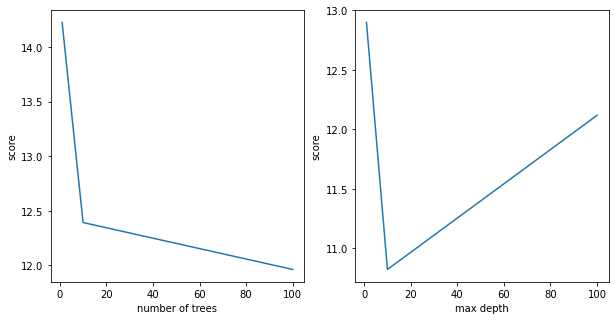

In [20]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

In [21]:
model = RandomForestClassifier(n_estimators = best_n, max_depth = best_m)
model.fit(train_kobe, train_label)

RandomForestClassifier(max_depth=10)